In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import yfinance as yf

# For time stamps
from datetime import datetime

yf.pdr_override()

df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Show the data
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.500195,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.567373,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.706894,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.839731,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.819362,394024400


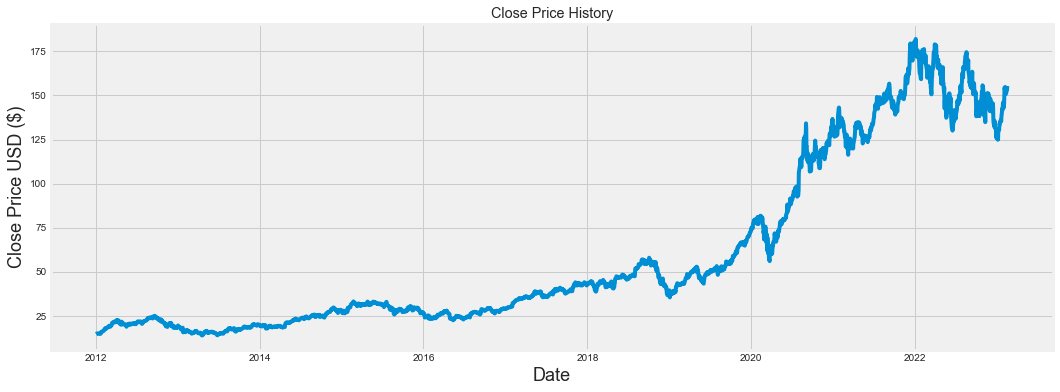

In [9]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [10]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

window_size = 60
training_data_len

2660

In [11]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# create scaler
scaler = StandardScaler()
# fit and transform in one step
scaled_data = scaler.fit_transform(dataset)

print ('scaled_data.shape',len(scaled_data))
scaled_data


scaled_data.shape 2799


array([[-0.92504669],
       [-0.92341947],
       [-0.92003983],
       ...,
       [ 1.94401478],
       [ 1.93061385],
       [ 1.97452714]])

## Train, test, validation data split

In [12]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len)]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])
    if i<= window_size + 1:
        print('x_train',x_train)
        print('\ny_train',y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print ('x_train.shape:',x_train.shape)

x_train [array([-0.92504669, -0.92341947, -0.92003983, -0.91682217, -0.9173155 ,
       -0.91620368, -0.91671173, -0.91756585, -0.91872921, -0.91512867,
       -0.91188156, -0.91288294, -0.91836843, -0.91313329, -0.91828742,
       -0.89895943, -0.90045412, -0.89850291, -0.8942839 , -0.89172894,
       -0.89194246, -0.89273029, -0.88937275, -0.88621402, -0.88263556,
       -0.87685556, -0.86471391, -0.86452984, -0.85777055, -0.85271952,
       -0.86140052, -0.85805772, -0.85812398, -0.84875082, -0.85008355,
       -0.84761695, -0.84318439, -0.84071774, -0.83361241, -0.82843622,
       -0.82694152, -0.82641872, -0.83526909, -0.8374044 , -0.83708777,
       -0.82876752, -0.82642607, -0.82139711, -0.80954263, -0.79372681,
       -0.79668676, -0.79667941, -0.78524458, -0.78166612, -0.78421377,
       -0.78654047, -0.78896292, -0.78091513, -0.77539282, -0.77308083])]

y_train [-0.7787945686197529]

x_train [array([-0.92504669, -0.92341947, -0.92003983, -0.91682217, -0.9173155 ,
       -0.91

In [13]:
print (x_train.shape[1])

60


In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

def build_LSTM_model():
    input = tf.keras.layers.Input(
        shape=(x_train.shape[1], 1), name ="input"
    )
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True))(input)
    
    x = tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True))(x)
    
    x = tf.keras.layers.Bidirectional(LSTM(32, return_sequences=False, dropout=0.5))(x)
    
    x = tf.keras.layers.Dense(25 , activation="relu", name ="dense_1")(x)
    
    output = tf.keras.layers.Dense(1, name="last_dense")(x)
               
    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

LSTM_model = build_LSTM_model()
LSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 60, 1)]           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 60, 256)          133120    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 60, 128)          164352    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 25)                1625      
                                                             

In [15]:
epochs = 100
batch_size = 20
early_stopping_patience = 17


# Compile the model
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = LSTM_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/100
130/130 [==============================] - 15s 68ms/step - loss: 0.0302
Epoch 2/100
130/130 [==============================] - 9s 68ms/step - loss: 0.0069
Epoch 3/100
130/130 [==============================] - 9s 73ms/step - loss: 0.0056
Epoch 4/100
130/130 [==============================] - 9s 71ms/step - loss: 0.0045
Epoch 5/100
130/130 [==============================] - 9s 72ms/step - loss: 0.0050
Epoch 6/100
130/130 [==============================] - 12s 91ms/step - loss: 0.0036
Epoch 7/100
130/130 [==============================] - 10s 77ms/step - loss: 0.0042
Epoch 8/100
130/130 [==============================] - 10s 79ms/step - loss: 0.0032
Epoch 9/100
130/130 [==============================] - 10s 74ms/step - loss: 0.0034
Epoch 10/100
130/130 [==============================] - 10s 80ms/step - loss: 0.0033
Epoch 11/100
130/130 [==============================] - 10s 75ms/step - loss: 0.0033
Epoch 12/100
130/130 [==============================] - 10s 75ms/step - loss: 

130/130 [==============================] - 11s 84ms/step - loss: 0.0014
Epoch 98/100
130/130 [==============================] - 11s 85ms/step - loss: 0.0013
Epoch 99/100
130/130 [==============================] - 11s 81ms/step - loss: 0.0014
Epoch 100/100
130/130 [==============================] - 11s 85ms/step - loss: 0.0014


dict_keys(['loss'])


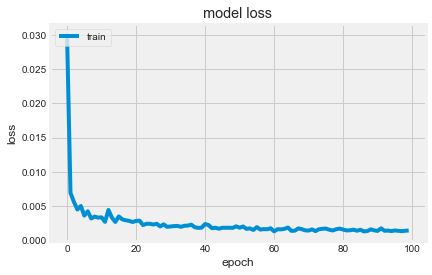

In [16]:
# list all data in history
print(history.history.keys())

# summarize history for loss

fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [17]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - window_size: ]
print ('len(test_data):', len(test_data))

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = LSTM_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

len(test_data): 199
5/5 [==============================] - 2s 38ms/step


3.2761129613089257

<ipython-input-18-aeddc951852c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


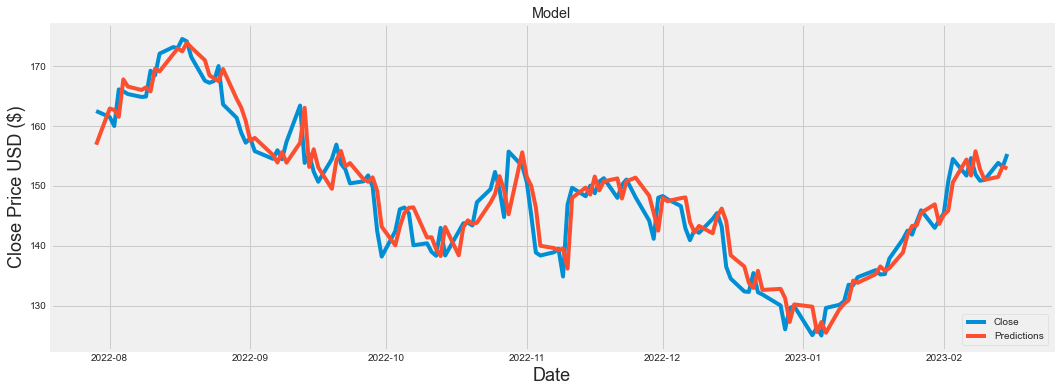

In [18]:
# Plot the data
train = data[:training_data_len]
test = data[training_data_len:]
test['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Close', 'Predictions'], loc='lower right')
plt.show()

In [19]:
# Show the valid and predicted prices
test

,Close,Predictions
Date,,
2022-07-29,162.509995,156.884964
2022-08-01,161.509995,162.927292
2022-08-02,160.009995,162.696152
2022-08-03,166.130005,161.547714
2022-08-04,165.809998,167.798264
...,...,...
2023-02-09,150.869995,152.772690
2023-02-10,151.009995,151.031357
2023-02-13,153.850006,151.509140
